<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p><strong>IMPORTANT</strong>
    
Depending on how your code is written, it is highly likely you will over-write variable names from Part 1, so be careful if you re-run cells above.</p></div>

## 8. Set-up non-linear functional model

In the model we fitted so far, we only considered a linear velocity and a dependency on the grounwater level. However, when a heavy construction is built on 'soft' soil layers, compaction of the upper layers will be observed. This compaction is relatively large in the beginning but decreases when time passes. We can approach the behavior with a simplified model, assuming an exponential decay. 

*Please note that this is very simplified model that does not necessarily rely on physics.* 

The new model is defined as
$$
d = d_0 + R \ \left(1-\exp\left(\frac{-t}{a}\right)\right) + k \ \textrm{GW},
$$
where $d$ is the displacement, $t$ is the time and $\textrm{GW}$ is the groundwater level. 

Therefore, the new model has 4 unknowns:
1. $d_0$, as the initial displacement at $t_0$;
2. $R$, which can be seen as the response of the soil layers to the extra weight of the road. Notice that when it is zero, there would be no compaction due to the extra loading;
3. $a$, as scaling parameter that represents the memory of the system;
4. $k$, as 'groundwater factor' that can be seen as the response of the layers due to changes in the groundwater level.

It can be seen that the model is non-linear. We will therefore use non-linear least-squares to solve for the unknown parameters. 



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8.1: </b>   
    
Choose initial values for the model parameters. Use the code and Markdown cells below to justify your decision. We suggest two possible approaches: a) use the forward model and make a plot to see if you can get it in the right order of magnitude, or b) make an inference about what the values might be using knowledge about each term in the model.
    
<i>Note: it may be useful at this point to define a function for your forward model to check the values. You will be able to re-use it in later Tasks as well.<i>
    
</p>
</div>

In [19]:
def forward_model(time, do_i, R_i, a_i, k_i, GW):
    """Compute the displacements based on our initial guess.
    """
    
    y_comp = do_i + R_i*(1-np.exp(-time/a_i))+k_i*GW
    
    return y_comp

In [20]:
# k_i = 
# R_i = 
# a_i = 
# do_i = 
# SOLUTION
k_i = 0.15
R_i = -25
a_i = 300
do_i = 9

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$

- For $d_0$ and $k$ you could use the estimated values from the linear model
    
- For $R$: realize that it is the difference between displacement at start and end of the observation interval (look at plot with data).
    
- For $a$: you could plot an exponential function $R \left(1-\exp\left(\frac{-t}{a}\right)\right)$ and try different values of $a$ to see which one would fit well here.
    


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8.2: </b>   
    
Set up the Jacobian matrix for the non-linear least-squares. Using the initial values from Task 8.1, print the first 5 rows of the Jacobian matrix to confirm that your function works correctly (i.e., confirm that code runs and initial values give acceptable results).
    

</p>
</div>

In [21]:
def jacobian(time, do_i, R_i, a_i, k_i, GW):
    """Create the Jacobian matrix.
    
    The columns represent the linearized system of equations.
    """    
    
    # J_c1 = 
    # J_c2 = 
    # J_c3 = 
    # J_c4 = 
    
    # SOLUTION
    J_c1 = np.ones(len(time))
    J_c2 = 1 - np.exp(-time/a_i)
    J_c3 = -R_i*time/a_i**2 * np.exp(-time/a_i)
    J_c4 = np.ones(len(time))*GW

    
    J = np.column_stack((J_c1, J_c2, J_c3, J_c4))
    
    return J

In [22]:
J_insar = jacobian(days_insar, do_i, R_i, a_i, k_i, GW_at_InSAR_times)

print ('The first 5 rows of the Jacobian matrix for InSAR are:')
print (J_insar[0:5,:])

n_2 = np.shape(J_insar)[1]
print(f'\nThe number of unknowns is {n_2}')
print(f'The redundancy (InSAR) is {m_insar - n_2}')
print(f'The redundancy (GNSS) is {m_gnss - n_2}')

The first 5 rows of the Jacobian matrix for InSAR are:
[[ 1.000e+00  0.000e+00  0.000e+00 -1.097e+02]
 [ 1.000e+00  3.921e-02  3.203e-03 -1.067e+02]
 [ 1.000e+00  7.688e-02  6.154e-03 -1.038e+02]
 [ 1.000e+00  1.131e-01  8.869e-03 -1.065e+02]
 [ 1.000e+00  1.479e-01  1.136e-02 -1.173e+02]]

The number of unknowns is 4
The redundancy (InSAR) is 57
The redundancy (GNSS) is 726


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8.3:</b>   
    
What is the redundancy of the model with InSAR and GNSS, respectively?
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$

- The number of unknowns is 4
- The redundancy (InSAR) is 57
- The redundancy (GNSS) is 726
    


## 9. Set-up Gauss-Newton iteration algorithm



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 9: </b>   
    
Set up a Gauss-Newton iteration algorithm (complete the code below). Choose the criterion to stop the iteration. 
Explain below how and why you define the stop-criterium. 

</p>
</div>

In [23]:
def nlsq_iteration(x0, day, y_obs, Sigma_Y, GW):
    """Use Gauss-Newton iteration to find non-linear parameters."""

    xnrm = 1000 # initialize stop criteria

    xhat_i = np.zeros((50, 4))
    xhat_i[0,:] = x0

    do_i = xhat_i[0,0]
    R_i = xhat_i[0,1]
    a_i = xhat_i[0,2]
    k_i = xhat_i[0,3]

    iter_ind = 0

    while xnrm >= 1e-12 and iter_ind < 49:

        # computed deformation yi based on 'estimates' 
        y_i = forward_model(day, do_i, R_i, a_i, k_i, GW)
        
        # dy = YOUR_CODE_HERE
        # SOLTUION
        dy = y_obs- y_i

        # J = YOUR_CODE_HERE
        # SOLTUION
        J = jacobian(day, do_i, R_i, a_i, k_i, GW)


        # d_xhat, Sigma_Xhat = YOUR_CODE_HERE
        # Hint: re-use your function BLUE, above
        # SOLUTION
        d_xhat, Sigma_Xhat = BLUE(J, dy, Sigma_Y)


        xhat_i[iter_ind+1,:] = xhat_i[iter_ind,:] + d_xhat.T

        do_i  = xhat_i[iter_ind+1,0]
        R_i  = xhat_i[iter_ind+1,1]
        a_i  = xhat_i[iter_ind+1,2]
        k_i = xhat_i[iter_ind+1,3]
        

        # xnrm = YOUR_CODE_HERE
        # SOLUTION
        xnrm = d_xhat.T @ np.linalg.inv(Sigma_Xhat) @ d_xhat

        # Update the iteration number
        iter_ind += 1

        if iter_ind==49:
            print("Number of iterations too large, check initial values.")

    xhat = xhat_i[iter_ind,:]
    xhat_i = xhat_i[0:iter_ind+1, :]
    return xhat, Sigma_Xhat, xhat_i, iter_ind, J


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>

We will use the 'weighted squared norm' of $\Delta \hat{\mathrm{x}}_{[i]}$, with the inverse covariance matrix $\Sigma_{\hat{X}}^{-1}$ as the weight matrix. In this way we account for different precisions of the parameters (high precision means we want the deviation to be smaller), as well as different order of magnitudes of the parameters.
    
</div>

## 10. Apply Gauss-Newton iteration



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 10.1: </b>   
    
Apply Gauss-Newton iteration on your model (run the code you completed above). 
    
For each unknown parameter, plot your estimates versus the iteration number (horizontal axis: iteration number, vertical axis: your estimate per iteration).

<i>For this Task, your output should include 8 plots at minimum (presenting additional values is also fine if it is relevant to your interpretation answers below).<i>
</p>
</div>

In [24]:
x0 = [do_i, R_i, a_i,k_i]

[xhat_insar, Sigma_Xhat_insar, xhat_i_insar, niter_insar, J_final_insar] = \
    nlsq_iteration(x0, days_insar, y_insar, Sigma_Y_insar, GW_at_InSAR_times)

[xhat_gnss, Sigma_Xhat_gnss, xhat_i_gnss, niter_gnss, J_final_gnss] = \
    nlsq_iteration(x0, days_gnss, y_gnss, Sigma_Y_gnss, GW_at_GNSS_times)

print('\n InSAR Reults for each iteration (#Interations =', niter_insar, ')')
print(xhat_i_insar)

print('\n GNSS Reults for each iteration (#Interations =', niter_gnss, ')')
print(xhat_i_gnss)


 InSAR Reults for each iteration (#Interations = 7 )
[[ 9.000e+00 -2.500e+01  3.000e+02  1.500e-01]
 [ 1.273e+01 -1.982e+01  1.407e+02  1.726e-01]
 [ 1.296e+01 -2.162e+01  1.768e+02  1.719e-01]
 [ 1.297e+01 -2.192e+01  1.793e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]
 [ 1.297e+01 -2.192e+01  1.794e+02  1.713e-01]]

 GNSS Reults for each iteration (#Interations = 10 )
[[ 9.000e+00 -2.500e+01  3.000e+02  1.500e-01]
 [ 3.747e+00 -1.777e+01  2.435e+02  1.425e-01]
 [ 3.895e+00 -1.812e+01  2.269e+02  1.418e-01]
 [ 3.939e+00 -1.815e+01  2.247e+02  1.416e-01]
 [ 3.945e+00 -1.815e+01  2.242e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01]
 [ 3.946e+00 -1.815e+01  2.241e+02  1.415e-01

In [25]:
# def plot_fit_iteration(xhat_i):
#     """Plot value of each parameter, each iteration."""
#     plt.figure(figsize = (15,4))
#     plt.subplots_adjust(top = 2)

#     plt.subplot(2,2,1)
#     YOUR_CODE_HERE
    
#     plt.subplot(2,2,2)
#     YOUR_CODE_HERE
    
#     plt.subplot(2,2,3)
#     YOUR_CODE_HERE
    
#     plt.subplot(2,2,4)
#     YOUR_CODE_HERE
    
def plot_fit_iteration(xhat_i):
    """Plot value of each parameter, each iteration."""
    plt.figure(figsize = (15,4))
    plt.subplots_adjust(top = 2)

    plt.subplot(2,2,1)
    plt.plot(xhat_i[:,0], linewidth=4)
    plt.title('Estimated offset')
    plt.ylabel('Offset [mm]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,2)
    plt.plot(xhat_i[:,1], linewidth=4)
    plt.title('Estimated R value')
    plt.ylabel('Estimated R value [mm]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,3)
    plt.plot(xhat_i[:,2], linewidth=4)
    plt.title('Estimated $a$ value')
    plt.ylabel('a value [days]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(2,2,4)
    plt.plot(xhat_i[:,3], linewidth=4)
    plt.title('Estimated GW factor')
    plt.ylabel('Estimated GW factor [-]')
    plt.xlabel('Number of iterations [-]')

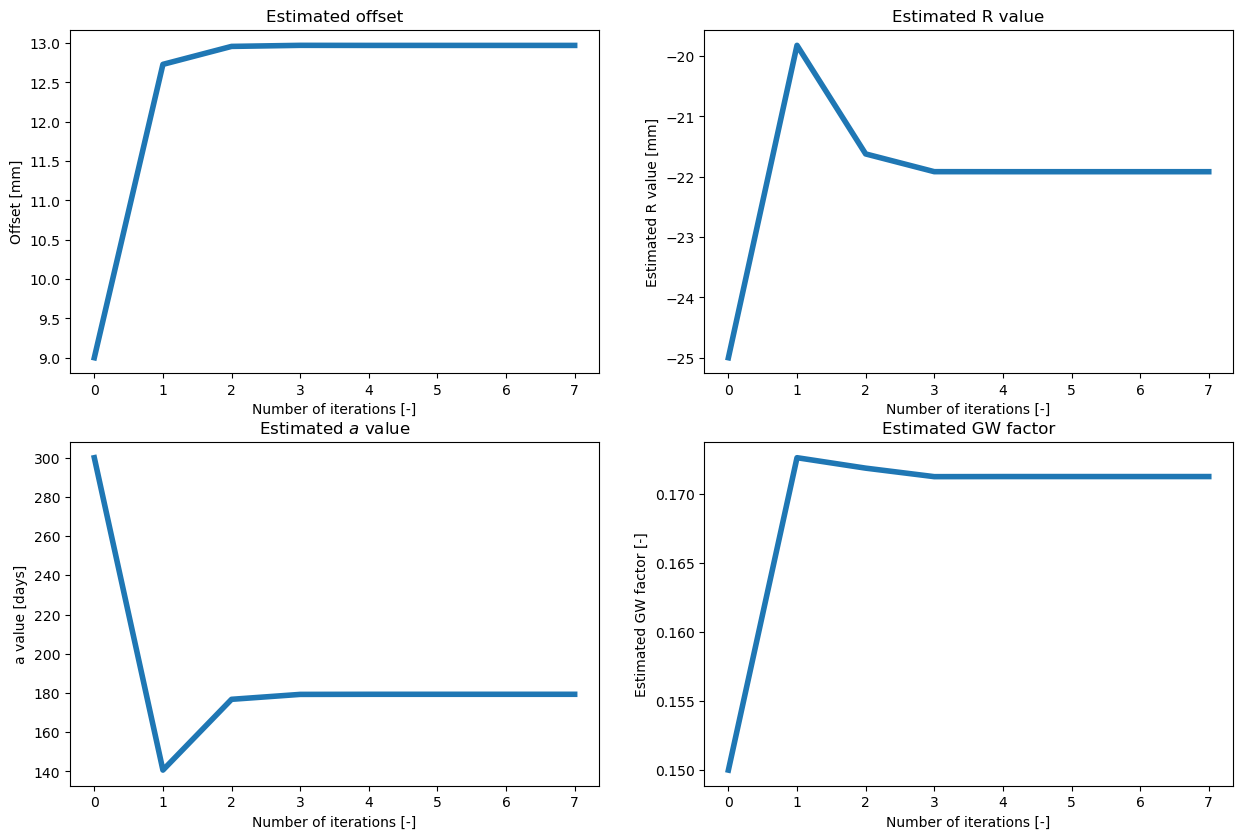

In [26]:
plot_fit_iteration(xhat_i_insar)

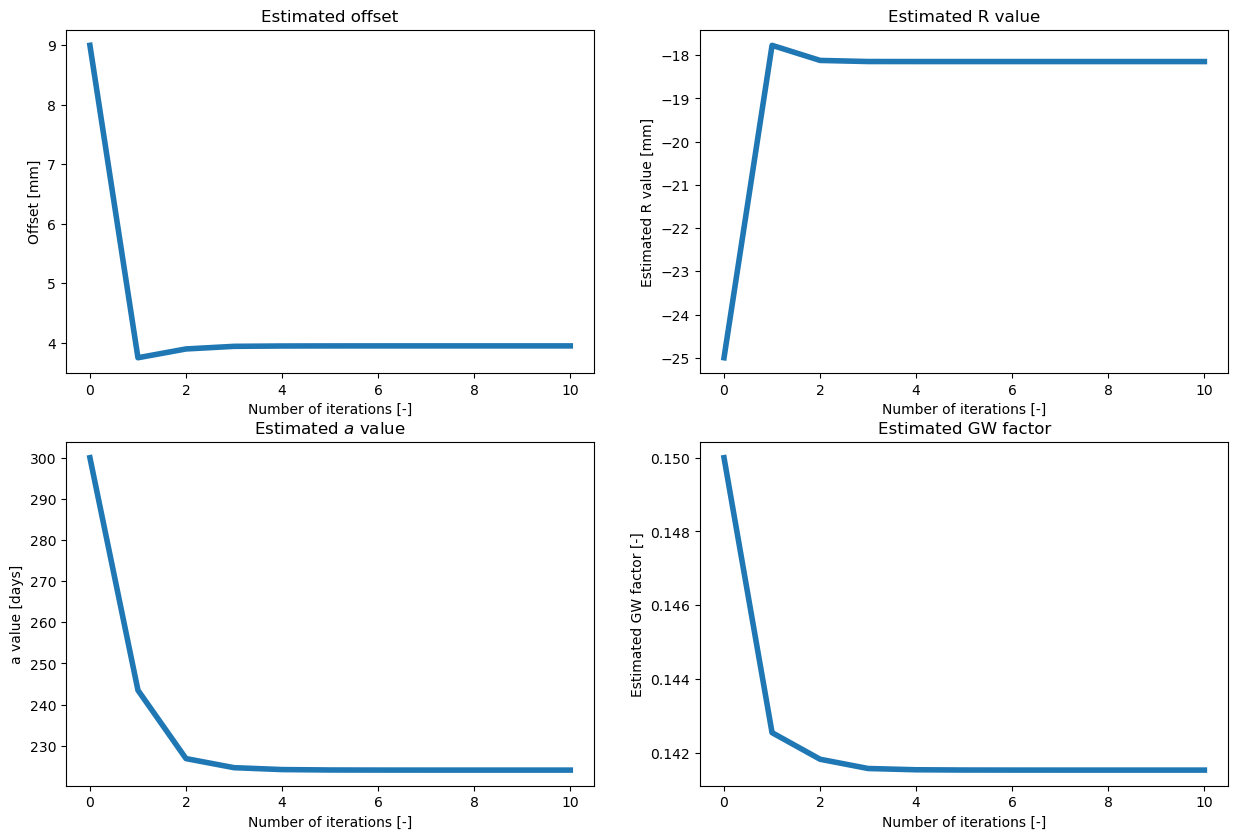

In [27]:
plot_fit_iteration(xhat_i_gnss)

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 10.2: </b>   
    
- Does your iteration converge? If not, find out why and provide an explanation.

- After how many iterations does it converge? 
    
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$ 

It converged! With InSAR only 5 iterations, with GNSS 8 iterations. This might be due to the difference in precision and number of observations.

    
</div>

## 11. Assess the precision of the estimates

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 11: </b>     
    
What is the quality of the final estimates? 
    
Provide the full covariance matrix of your estimates, and give an interpretation of the numbers in the covariance matrix.
    
</p>
</div>

In [28]:
def show_std(Sigma_Xhat, data_type):
    print ('The standard deviation for',
           data_type + '-offset is',
           np.round(np.sqrt(Sigma_Xhat[0,0]),2), 'mm')
    print ('The standard deviation for',
           data_type + '-R is',
           np.round(np.sqrt(Sigma_Xhat[1,1]),2), 'mm')
    print ('The standard deviation for',
           data_type + '-a is',
           np.round(np.sqrt(Sigma_Xhat[2,2]),2), 'days')
    print ('The standard deviation for',
           data_type + '-the ground water factor',
           np.round(np.sqrt(Sigma_Xhat[3,3]),3), '[-]')

In [29]:
print ('Covariance matrix of estimated parameters (InSAR):')
print (Sigma_Xhat_insar, '\n')
show_std(Sigma_Xhat_insar, 'InSAR')
print ('\nCovariance matrix of estimated parameters (GNSS):')
print (Sigma_Xhat_gnss, '\n')
show_std(Sigma_Xhat_gnss, 'GNSS')

Covariance matrix of estimated parameters (InSAR):
[[ 4.771e+00 -5.522e-01 -7.605e+00  3.183e-02]
 [-5.522e-01  1.017e+00  4.726e+00  2.657e-03]
 [-7.605e+00  4.726e+00  4.461e+02  6.328e-02]
 [ 3.183e-02  2.657e-03  6.328e-02  2.771e-04]] 

The standard deviation for InSAR-offset is 2.18 mm
The standard deviation for InSAR-R is 1.01 mm
The standard deviation for InSAR-a is 21.12 days
The standard deviation for InSAR-the ground water factor 0.017 [-]

Covariance matrix of estimated parameters (GNSS):
[[ 2.306e+01 -2.474e+00 -7.557e+01  1.514e-01]
 [-2.474e+00  4.674e+00  2.167e+00  6.718e-03]
 [-7.557e+01  2.167e+00  6.317e+03  4.459e-01]
 [ 1.514e-01  6.718e-03  4.459e-01  1.289e-03]] 

The standard deviation for GNSS-offset is 4.8 mm
The standard deviation for GNSS-R is 2.16 mm
The standard deviation for GNSS-a is 79.48 days
The standard deviation for GNSS-the ground water factor 0.036 [-]


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$

The precision of the estimated offset $\hat{d}_0$ and $\hat{k}$ is approximately 2 mm and 0.02, respectively. With GNSS the of those parameters is a approximately a factor 2 worse due to the higher noise in the data. However, due to the high number of observations, the precision is still rather good. Note that the outliers do not have an impact on the precision, since the covariance matrix does not depend on the data (and outliers are non-random errors that are not accounted for in the covariance matrix).
Precision of parameters is good if compared to estimated values, except for $a$ and for GNSS also $R$ is less precise (std of 35 days, while estimated value is -15 days). This can only be explained by the higher noise in GNSS data, such that the exponential signal 'drowns' in the noise.

    
</div>

## 12. Present the estimation results



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 12.1:</b>   
    
Compute the modeled displacements ($\hat{\mathrm{y}}$), and corresponsing residuals ($\hat{\mathrm{\epsilon}}$). 
Visualize the results in two graphs and add the confidence bounds ($t$-versus-displacement and $t$-versus-residuals).

Also create a histogram of the residuals where you plot the normal distribution (which you can estimate from the histogram) as well and report the mean and sigma of the residuals. 
</p>
</div>

The mean value of the InSAR residuals is 0.0 mm
The standard deviation of the InSAR residuals is 1.852 mm


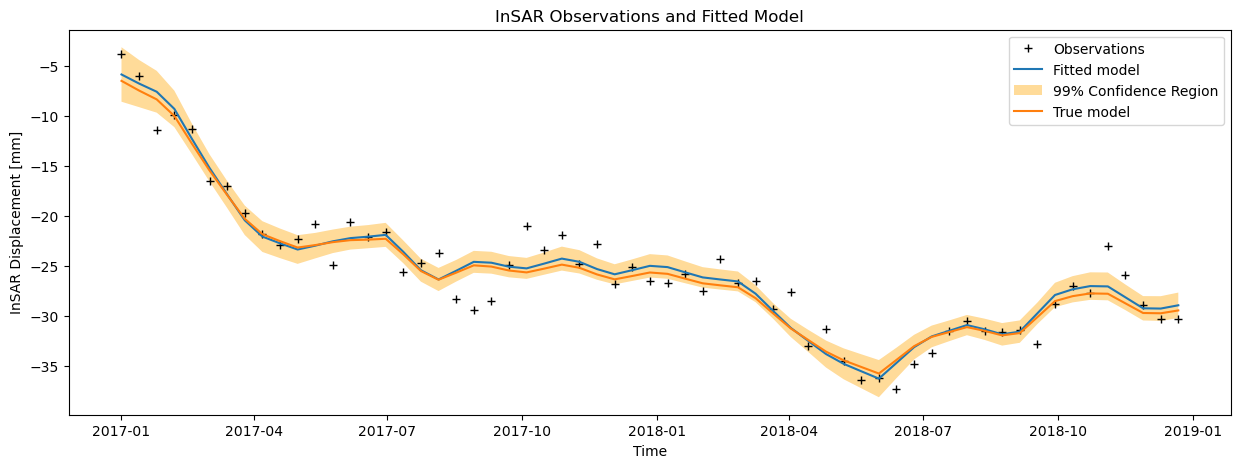

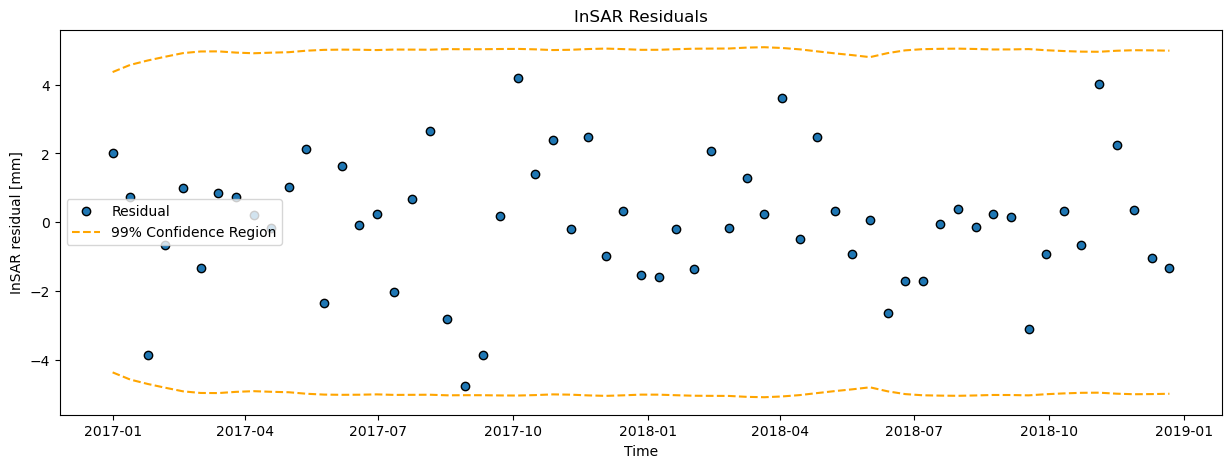

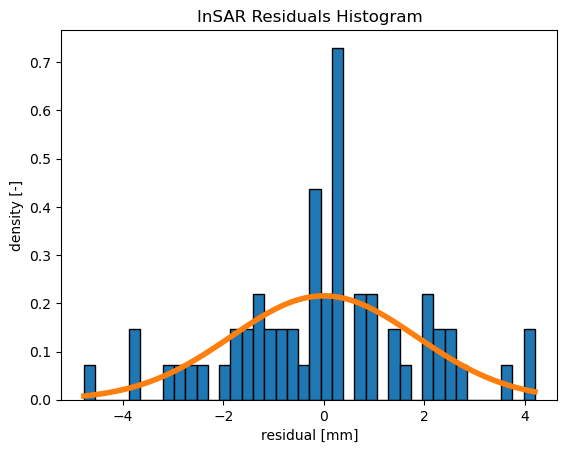

In [30]:
yhat_insar_2 = forward_model(days_insar, xhat_insar[0], xhat_insar[1], xhat_insar[2],\
                             xhat_insar[3], GW_at_InSAR_times)
ehat_insar_2 = plot_residual(dates_insar, y_insar, yhat_insar_2,
                              'InSAR', J_final_insar, Sigma_Xhat_insar,
                              Sigma_Y_insar, disp_insar)

The mean value of the GNSS residuals is 0.0 mm
The standard deviation of the GNSS residuals is 15.315 mm


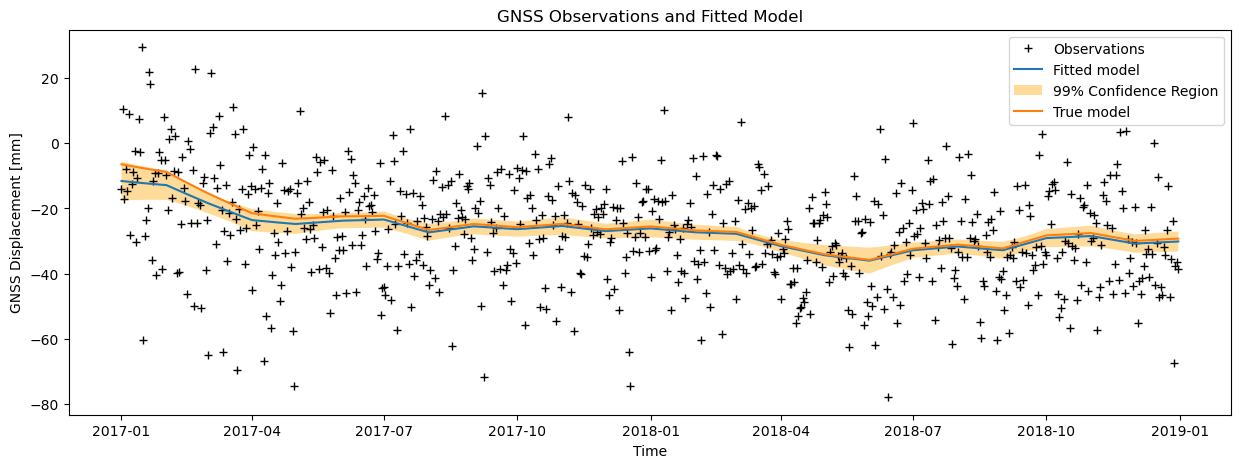

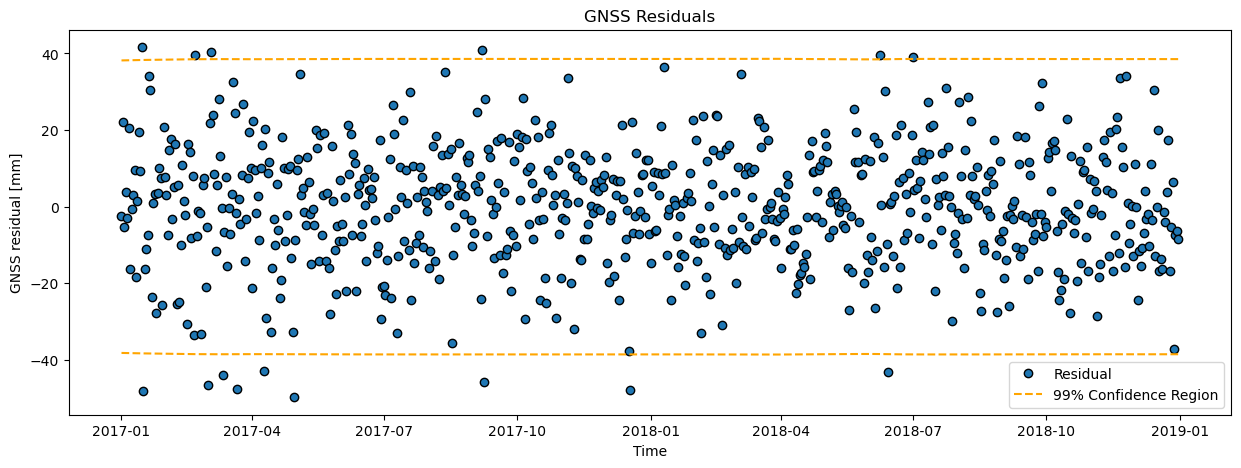

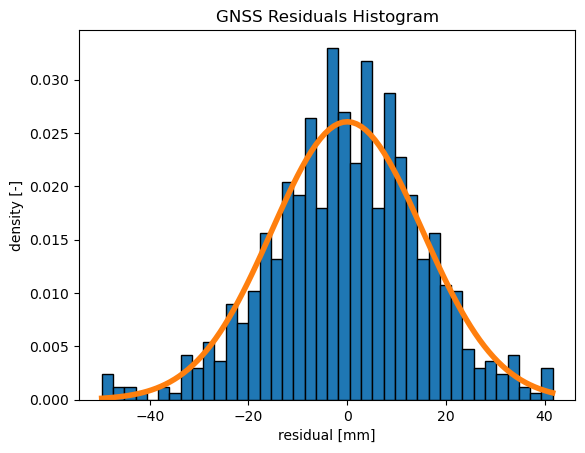

In [31]:
yhat_gnss_2 = forward_model(days_gnss, xhat_gnss[0], xhat_gnss[1], xhat_gnss[2],\
                             xhat_gnss[3], GW_at_GNSS_times)
ehat_gnss_2 = plot_residual(dates_gnss, y_gnss, yhat_gnss_2,
                             'GNSS', J_final_gnss, Sigma_Xhat_gnss,
                             Sigma_Y_gnss, disp_gnss)

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 12.2:</b>   

Answer the following questions:
<ol>
    <li>Do you see any systematic effect?</li>
    <li>Give your interpretation for any discrepancy between observations and the model?</li>
    <li>What is the mean value of the residuals and what does this value tells you?</li>
    <li>And what is the empirical standard deviation of the residuals? Do you recognise this value?</li>
</ol>
</p>
</div>




**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$


The InSAR discrepancies look as expected, no systematic effects: the residuals have a zero-mean and standard deviation close to the precision of the observables. This tells us that the precision that we used for the observations corresponds to the true noise level. 
    
For GNSS there are still many residuals at the start of the observation period which are outside the confidence bounds, also resulting in slightly larger empirical standard deviation of the residuals. The effect of the outliers is also visible when comparing the fitted model with GNSS and InSAR : for GNSS it is pulled 'downwards'.
</div>

## 13. Strategies to improve?


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 13:</b>   

In order to get a better fit to the data (smaller residuals) for this case study, which of the following strategies could help? (elaborate on your answer)
<ol>
    <li>better observations?</li>
    <li>a more complicated geophysical model?</li>
    <li>better initial values?</li>
    <li>more observations?</li>
</ol>
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$
<ol>
    <li>better observations will help, and should result in smaller residuals.</li>
    <li>a more complicated geophysical model will help if it is able to capture the signal. However, since we don't see any systematic effects in the InSAR residuals, it is not expected that much gain can be expected. Including more parameters in the model will help to get smaller residuals, but is there still a geophysical explanation...?</li>
    <li>better initial values will not help, since solution converged to valid results.</li>
    <li>more observations generally helps, as long as they are not corrupted by outliers or systematic effects.</li>
</ol> 
</div>

## 14. Apply hypothesis test

In the assignment we used two different models:
* A linear model
* A model with linear and power components

Now we are going to test which model fits the data better. We will do this with the Generalized Likelihood Ratio (GLR) test for both the GNSS and InSAR observations





<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 14: </b>   

The critical value is computed with level of significance $\alpha=0.005$ the test statistics is computed in the code below.
    
Answer the following questions:
<ol>
    <li>What is the null hypothesis $H_0$ and alternative hypothesis $H_a$ in this test?</li>
    <li>How can you compute the test statistic? What is its distribution?</li>
</ol>
</p>
</div>


In [32]:
q = 1 #Degree of freedom
alpha = 0.005 

# Critical value
k = chi2.ppf(1 - alpha, df=q)
print(f'The critical value is {np.round(k, 3)}')

The critical value is 7.879


In [33]:
t1_insar = ehat_insar_1.T @ np.linalg.inv(Sigma_Y_insar) @ ehat_insar_1
t2_insar = ehat_insar_2.T @ np.linalg.inv(Sigma_Y_insar) @ ehat_insar_2
t_insar = t1_insar - t2_insar
print(f'The test statistic for InSAR data is {np.round(t_insar, 3)}')

The test statistic for InSAR data is 95.616


In [34]:
t1_gnss = ehat_gnss_1.T @ np.linalg.inv(Sigma_Y_gnss) @ ehat_gnss_1
t2_gnss = ehat_gnss_2.T @ np.linalg.inv(Sigma_Y_gnss) @ ehat_gnss_2
t_gnss = t1_gnss - t2_gnss
print(f'The test statistic for GNSS data is {np.round(t_gnss, 3)}')

The test statistic for GNSS data is 7.788


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$ 
<ol>
    <li>The null hypothesis is that we assume that the linear model is correct, the alternative hypothesis that the model is incorrect.</li>
    <li>The test statistic is the difference of the weighted squared norms of residuals, and has a Chi-squared distribution with 1 degree of freedom, since there is 1 extra parameter in the alternative hypothesis model as compared to the null hypothesis.</li>
</ol>
</div>

## 15. Interpretation of test outcomes




<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 15: </b>   
    
Answer the following questions:
<ol>
    <li>What are the test statistic values for the two models (linear model and exponential model) for both the InSAR and the GNSS observations?</li>
    <li>What is to be concluded based on the individual test outcomes (i.e., for GNSS and InSAR)?</li>
    <li>Please compare the different test outcomes with InSAR and GNSS and discuss/explain them here.</li> 
</ol>
</p>
</div>


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$  
    
- For InSAR the the test statistic is 115.5 which is significantly larger than the critical value. Therefore the exponential model is accepted in favour of the linear one. 

- For GNSS the outcomes is different: test statistic is equal to 6.4, which is smaller than the critical value, resulting in acceptance of the null hypothesis (i.e., linear model). The reason is that the GNSS data is much noisier and contains many outliers, such that an exponential trend cannot be distinguished.
</div>

## 16. How to deal with 2 datasets?

Data acquisition and processing comes with a price. Note that in a real situation you would not look at a time series of only one point. For Sentinel-1 data you may have to pay, collecting GNSS data at different locations also costs money. 


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 16: </b>   
    How will you monitor the deformation if you have both GNSS and InSAR data at your disposal?
</p>
</div>


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>
    <li>Use the observations together (i.e., estimate the unknown parameters using the GNSS and InSAR observations at the same time, which would result in 791 observations). With BLUE we would of course apply proper weights, taking into account the different precisions.</li>
</div>

<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p> <b>Disclaimer:</b> the outliers in the GNSS data were added manually, and do not necessarily represent reality, which means that you cannot conclude from this assignment that InSAR is better than GNSS. Without the outliers, GNSS would have given you different results and then the larger noise would be compensated by the higher sampling rate.</p></div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.